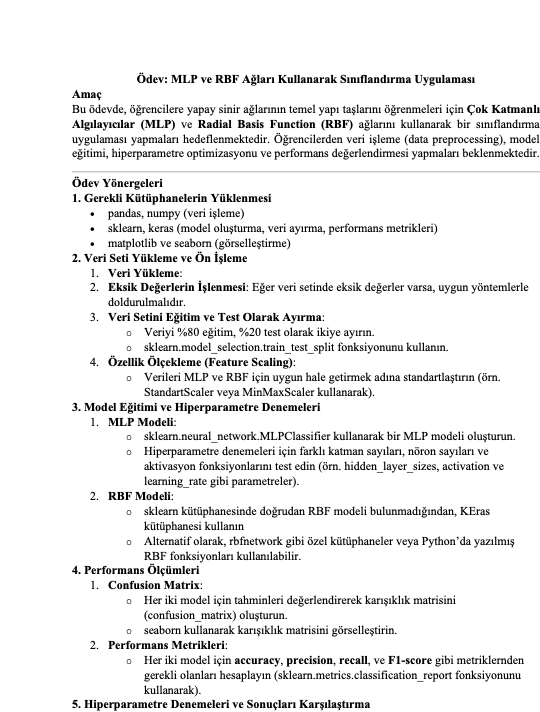

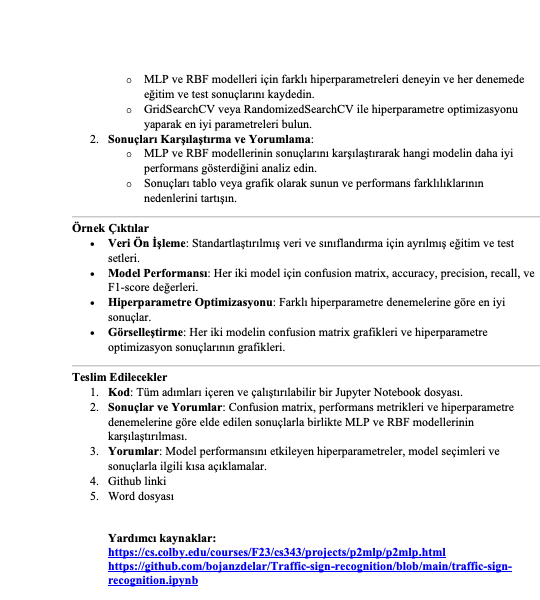

# **RBF MODELİ**

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Dropout,LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.metrics import Precision, Recall,Accuracy
from keras import optimizers
import cv2
import keras
from sklearn.decomposition import PCA
from keras.optimizers import RMSprop, Adam, Nadam

In [ ]:
import numpy as np


def get_distance(x1, x2):
    sum = 0
    for i in range(len(x1)):
        sum += (x1[i] - x2[i]) ** 2
    return np.sqrt(sum)


def kmeans(X, k, max_iters):

    centroids = X[np.random.choice(range(len(X)), k, replace=False)]

    converged = False

    current_iter = 0

    while (not converged) and (current_iter < max_iters):

        cluster_list = [[] for i in range(len(centroids))]

        for x in X:  # Go through each data point
            distances_list = []
            for c in centroids:
                distances_list.append(get_distance(c, x))
            cluster_list[int(np.argmin(distances_list))].append(x)

        cluster_list = list((filter(None, cluster_list)))

        prev_centroids = centroids.copy()

        centroids = []

        for j in range(len(cluster_list)):
            centroids.append(np.mean(cluster_list[j], axis=0))

        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        print('K-MEANS: ', int(pattern))

        converged = (pattern == 0)

        current_iter += 1

    return np.array(centroids), [np.std(x) for x in cluster_list]


class RBF:

    def __init__(self, X, y, tX, ty, num_of_classes,
                 k, std_from_clusters=True):
        self.X = X
        self.y = y

        self.tX = tX
        self.ty = ty

        self.number_of_classes = num_of_classes
        self.k = k
        self.std_from_clusters = std_from_clusters

    def convert_to_one_hot(self, x, num_of_classes):
        arr = np.zeros((len(x), num_of_classes))
        for i in range(len(x)):
            c = int(x[i])
            arr[i][c] = 1
        return arr

    def rbf(self, x, c, s):
        distance = get_distance(x, c)
        return 1 / np.exp(-distance / s ** 2)

    def rbf_list(self, X, centroids, std_list):
        RBF_list = []
        for x in X:
            RBF_list.append([self.rbf(x, c, s) for (c, s) in zip(centroids, std_list)])
        return np.array(RBF_list)

    def fit(self):

        self.centroids, self.std_list = kmeans(self.X, self.k, max_iters=1000)

        if not self.std_from_clusters:
            dMax = np.max([get_distance(c1, c2) for c1 in self.centroids for c2 in self.centroids])
        self.std_list = np.repeat(dMax / np.sqrt(2 * self.k), self.k)

        RBF_X = self.rbf_list(self.X, self.centroids, self.std_list)

        self.w = np.linalg.pinv(RBF_X.T @ RBF_X) @ RBF_X.T @ self.convert_to_one_hot(self.y, self.number_of_classes)

        RBF_list_tst = self.rbf_list(self.tX, self.centroids, self.std_list)

        self.pred_ty = RBF_list_tst @ self.w

        self.pred_ty = np.array([np.argmax(x) for x in self.pred_ty])

        diff = self.pred_ty - self.ty

        print('Accuracy: ', len(np.where(diff == 0)[0]) / len(diff))



(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_y = y_train[0:60000]
train_x = x_train[0:60000].reshape(60000, -1)

test_y = y_test[0:10000]
test_x = x_test[0:10000].reshape(10000, -1)

RBF_CLASSIFIER = RBF(train_x, train_y, test_x, test_y, num_of_classes=10,
                     k=5, std_from_clusters=False)

RBF_CLASSIFIER.fit()

11490434/11490434 [==============================] - 0s 0us/step


<ipython-input-3-883643dc2bfd>:7: RuntimeWarning: overflow encountered in scalar subtract
  sum += (x1[i] - x2[i]) ** 2


K-MEANS:  8314
K-MEANS:  1691
K-MEANS:  7450
K-MEANS:  5104
K-MEANS:  1954
K-MEANS:  786
K-MEANS:  427
K-MEANS:  429
K-MEANS:  521
K-MEANS:  620
K-MEANS:  711
K-MEANS:  770
K-MEANS:  815
K-MEANS:  809
K-MEANS:  854
K-MEANS:  860
K-MEANS:  853
K-MEANS:  787
K-MEANS:  822
K-MEANS:  827
K-MEANS:  715
K-MEANS:  579
K-MEANS:  471
K-MEANS:  340
K-MEANS:  244
K-MEANS:  146
K-MEANS:  19
K-MEANS:  10
K-MEANS:  37
K-MEANS:  20
K-MEANS:  17
K-MEANS:  8
K-MEANS:  9
K-MEANS:  11
K-MEANS:  20
K-MEANS:  20
K-MEANS:  13
K-MEANS:  14
K-MEANS:  10
K-MEANS:  6
K-MEANS:  1
K-MEANS:  0
K-MEANS:  2
K-MEANS:  3
K-MEANS:  0
K-MEANS:  1
K-MEANS:  0
Accuracy:  0.5076


Class tanımlayarak yaptığımız bu modelde oldukça düşük bir Acuuracy oranı aldık %50. Hiperparametre optimizasyonu,GridSearchCV ya da RandomSearchCv gibi yöntemlerle en iyi parametreler bulunup çok daha iyi sonuçlar alınabilir.